# C-Z Quantum Gate
### (Using three pulse sequence, with a phase shift in the mid of second pulse)
          (Neutral Atom Quantum Gate Noisy Simulation)

> Devesh Kumar          
> MSc Physics-II
  

In [1]:
#Some imports from Pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation, SimConfig

#Some general imports
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt
import qutip
from itertools import product

import qiskit
from qiskit.visualization import *

In [24]:
print('The unitary matrix operator of C-NOT gate:')
u = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

array_to_latex(u)

The unitary matrix operator of C-NOT gate:


<IPython.core.display.Latex object>

## Defining Register
The Register defines the positions of the atoms and their names. Here we've two atoms seprated by a distance of $10\mu m$, named `C` and `T` for 'control' and 'target' respectively.

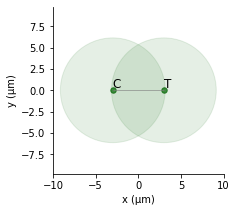

In [2]:
qubits = {'C': (-3,0) , 'T': (3,0) }

Omega_max = pi/2
blockade_radius = Chadoq2.rydberg_blockade_radius(Omega_max)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)

## State preparation
The first part of the sequence corresponds to preparing the different states on which the CZ gate will act. For this, we define the following Pulse instances that correspond to $\pi$ pulse.

In [3]:
#function that takes the label string of a state and turns it into a ket state

def state_prep(sid, basis):
    ids = {'digital': 'ge', 'ground-rydberg': 'rg', 'all': 'rge'}
    
    ket = {k: qutip.basis(len(ids[basis]), i) 
           for i, k in enumerate(ids[basis])}
    
    return qutip.tensor([ket[x] for x in sid])

State preparation sequence:

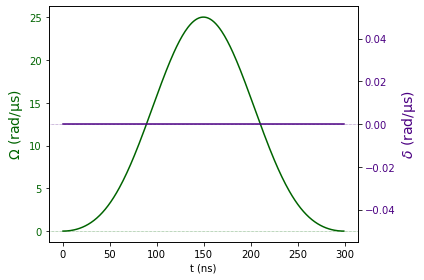

In [4]:
pi_wf = BlackmanWaveform(300, np.pi)
pi_y = Pulse.ConstantDetuning(pi_wf, 0, -np.pi/2)

pi_y.draw()

In [5]:
def prep_seq(sid, reg):
    global seq
    
    if len(sid) != len(reg.qubits):
        raise ValueError('Not a valid state ID.')
    
    seq = Sequence(reg, Chadoq2)
    seq_dict = {'1':'T', '0':'C'}
    
    if sid == 'gg':
        basis = 'ground-rydberg'
    else:
        basis = 'all'
        for i in range(len(reg.qubits)):
            if sid[i] == 'e':
                if 'raman' not in seq.declared_channels:
                    seq.declare_channel('raman','raman_local', seq_dict[str(i)])
                else:
                    seq.target(seq_dict[str(i)],'raman')
                seq.add(pi_y,'raman')
            
    prep_state = state_prep(sid, basis)
            
    return prep_state

## Gate Sequence Preparation
We apply the three pulse $\pi-2\pi-\pi$ sequence for CZ gate. 

In [6]:
#Defining pulses
pi_wf = BlackmanWaveform(200, np.pi)
pi_m = Pulse.ConstantDetuning(pi_wf, 0, -pi/2)

pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)
pi_p = Pulse.ConstantDetuning(pi_wf, 0, pi/2, pi)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

half_pi_wf = BlackmanWaveform(100, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)#, post_phase_shift=np.pi)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)#, post_phase_shift=np.pi)

In [7]:
def CZ_seq(int_id):

    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)
    
    #Declare Rydberg channel
    seq.declare_channel('ryd', 'rydberg_local', 'C')
    
    seq.target('C', 'ryd')
    seq.add(pi_pulse, 'ryd', 'wait-for-all')
    
    seq.target('T', 'ryd')
    seq.add(pi_p, 'ryd')
    seq.add(pi_m, 'ryd', 'no-delay')
    
    seq.target('C', 'ryd')
    seq.add(pi_pulse, 'ryd')

    return prep_state, prep_time

### Visualising sequence



 Visualization for the initial state '10': 



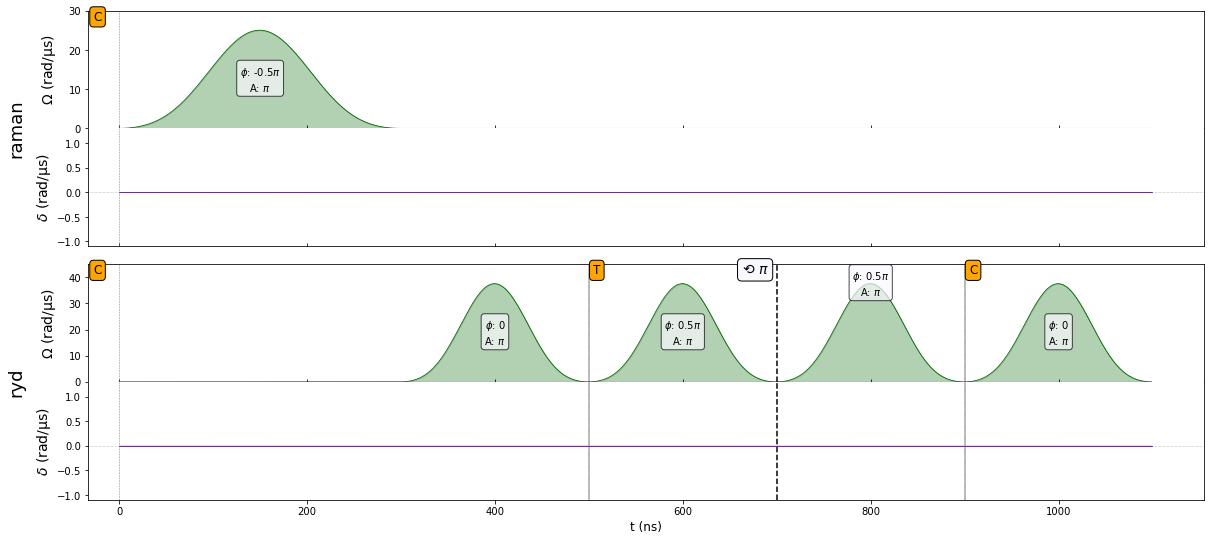


 Prepared state --> Quantum object: dims = [[3, 3], [1, 1]], shape = (9, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

 Preparation time: 300ns 


Channel: raman
t: 0 | Initial targets: C | Phase Reference: 0.0 
t: 0->300 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=4.71) | Targets: C

Channel: ryd
t: 0 | Initial targets: C | Phase Reference: 0.0 
t: 0->300 | Delay 
t: 300->500 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: C
t: 500->500 | Target: T | Phase Reference: 0.0
t: 500->700 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=1.57) | Targets: T
t: 700->900 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=1.57) | Targets: T
t: 900->900 | Target: C | Phase Reference: 0.0
t: 900->1100 | Pulse(Amp=Blackman(Area: 3.14), Detuning=0 rad/µs, Phase=0) | Targets: C




In [10]:
print(f"\n\n Visualization for the initial state '10': \n")
prep_state, prep_time = CZ_seq('eg')
seq.draw(draw_phase_area=True,draw_phase_shifts=True)
print(f'\n Prepared state --> {prep_state}')
print(f'\n Preparation time: {prep_time}ns \n\n')
print(seq)

## Simulating the CZ-Sequence
We've introduce SPAM and Doppler damping errors with parameters `eta`: 0.08, `epsilon`: 0.01, and `epsilon_prime`: 0.05

In [11]:
def sim():
    st = {}
    states = []
    most_freq = [0]*4
    L = ['gg', 'eg','ge','ee']
    for i in range(len(L)):
        # Get CZ sequence
        prep_state, prep_time = CZ_seq(L[i]) # constructs seq, prep_state and prep_time
    
        # Construct Simulation instance
        sim = Simulation(seq)
        #cfg = SimConfig(noise=('SPAM', 'doppler'), eta=0.08, temperature=500, runs=1000) 
        #sim.set_config(cfg)

        res = sim.run()
        st[L[i]] = res.states[-1].overlap(prep_state)
        states.append(st[L[i]])
        
        count = res.sample_final_state(N_samples=1e3)
    
        print(f'{i+1}) {L[i]}: {count}\n')
        
        #display(plot_histogram(count))
        
    return st, states

In [12]:
st, states = sim()

print(f'\nOutput states:\n')
display(st)

1) gg: Counter({'00': 1000})

2) eg: Counter({'10': 1000})

3) ge: Counter({'01': 1000})

4) ee: Counter({'11': 1000})


Output states:



{'gg': (-0.9307163205099217+0.3657371109872742j),
 'eg': (-0.999999999698743+1.8369701981676312e-16j),
 'ge': (-0.9999999997041037+1.8369701981774722e-16j),
 'ee': (0.999999999897956-3.6739403970671444e-16j)}

In [13]:
m = np.diag(np.array(states))
array_to_latex(m)

<IPython.core.display.Latex object>

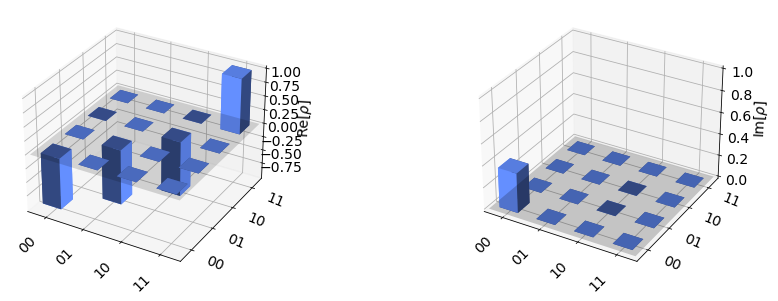

In [14]:
plot_state_city(m)

### Out


In [15]:
pi_p = Pulse.ConstantDetuning(pi_wf, 0, pi/2)

st2, states = sim()

print(f'\nOutput states:\n')
display(st2)

1) gg: Counter({'00': 1000})

2) eg: Counter({'10': 1000})

3) ge: Counter({'01': 1000})

4) ee: Counter({'11': 1000})


Output states:



{'gg': (-0.9307166170989597+0.36573677271806926j),
 'eg': (0.9999999999492595-3.0616169975594583e-16j),
 'ge': (-0.9999999997041021+1.8369701981774791e-16j),
 'ee': (0.9999999998979557-3.6739403970671434e-16j)}

In [16]:
pi_p = Pulse.ConstantDetuning(pi_wf, 0, pi/2, 3*pi)

st3, states = sim()

print(f'\nOutput states:\n')
display(st3)

1) gg: Counter({'00': 1000})

2) eg: Counter({'10': 1000})

3) ge: Counter({'01': 1000})

4) ee: Counter({'11': 1000})


Output states:



{'gg': (-0.9307163205099217+0.3657371109872742j),
 'eg': (-0.999999999698743+1.8369701981676312e-16j),
 'ge': (-0.9999999997041037+1.8369701981774722e-16j),
 'ee': (0.999999999897956-3.6739403970671444e-16j)}

## CNOT Implementation

In [10]:
def CNOT(int_id):
    
    #State Preparation
    prep_state = prep_seq(int_id, reg)
    prep_time = max((seq._last(ch).tf for ch in seq.declared_channels), default = 0)

    #Declare Rydberg channel
    if 'ryd' not in seq.declared_channels:
        seq.declare_channel('ryd', 'rydberg_local', 'C')
    if 'raman' not in seq.declared_channels:
        seq.declare_channel('raman','raman_local')
        
    #CNOT Sequence
    seq.target('T', 'raman')
    seq.add(half_pi_pulse, 'raman')
    seq.align('raman', 'ryd')
    
    
    
    seq.target('C', 'ryd')
    seq.add(pi_pulse, 'ryd', 'wait-for-all')
    
    seq.target('T', 'ryd')
    seq.add(pi_p, 'ryd')
    seq.add(pi_m, 'ryd', 'no-delay')
    
    seq.target('C', 'ryd')
    seq.add(pi_pulse, 'ryd')
    
    
    
    seq.align('raman', 'ryd')
#    seq.target('T', 'raman')
    seq.add(half_pi_pulse_d, 'raman')

        
    seq.measure('digital')
    return prep_state, prep_time

### Visualising sequence


Prepared state-


<IPython.core.display.Latex object>


Preparation time: 300ns


Plot:-



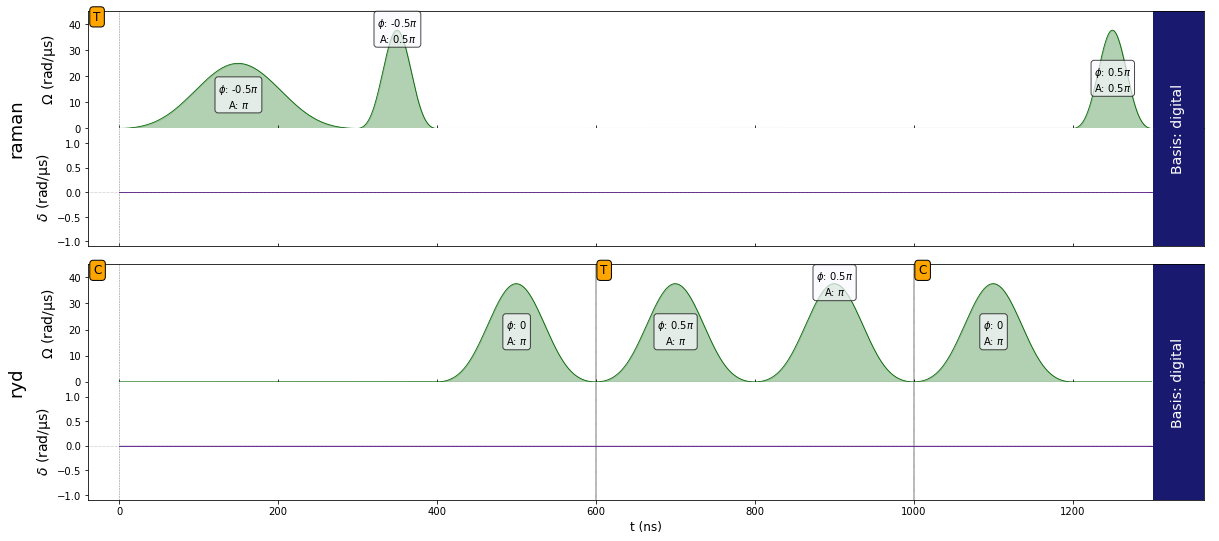

In [11]:
prep_state, prep_time = CNOT('ge')
print(f'\nPrepared state-')
display(array_to_latex(prep_state))
print(f'\nPreparation time: {prep_time}ns\n')
#print(f'Sequence:-\n{seq}')
print('\nPlot:-\n')
seq.draw(draw_phase_area=True)

### Simulating the CNOT sequence

In [12]:
def CNOT_Sim(sid, error=False, error2=False):

    # State prep
    prep_state, prep_time = CNOT(sid) # constructs seq, prep_state and prep_time
    
    print(f"\n\nOutput for the input state '{sid}':-\n\nPrepared state:")
    display(array_to_latex(prep_state))
    print(f'\nPreparation time: {prep_time}ns')

    # Construct Simulation instance
    sim = Simulation(seq)
    if (error==True):
        cfg = SimConfig(noise=('SPAM', 'doppler'),
                      eta=1e-6, epsilon=1e-6/2, epsilon_prime=1e-6*(2.5),runs = 1000) 
        sim.set_config(cfg)

    if (error2==True):
        cfg = SimConfig(noise=('SPAM', 'doppler'), eta=1e-6, runs = 1000) 
        sim.set_config(cfg)


    res = sim.run()
    final_state = res.get_final_state()

    count = res.sample_final_state(N_samples=1e3)
    print(f'\nCounts: {count}\n')
    
    display(plot_histogram(count))
    
    return final_state, count

### Without Error



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns

Counts: Counter({'00': 958, '01': 42})



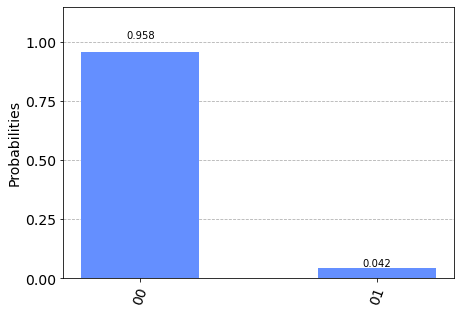



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'01': 962, '00': 38})



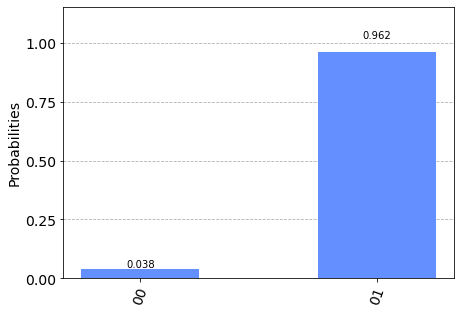



Output for the input state 'eg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'11': 1000})



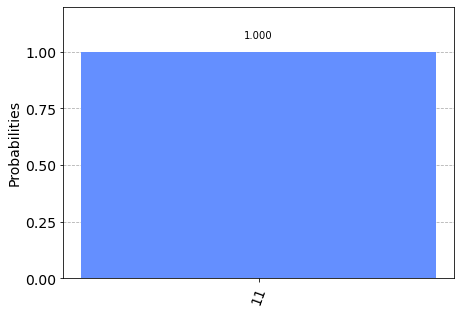



Output for the input state 'ee':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 600ns

Counts: Counter({'10': 1000})



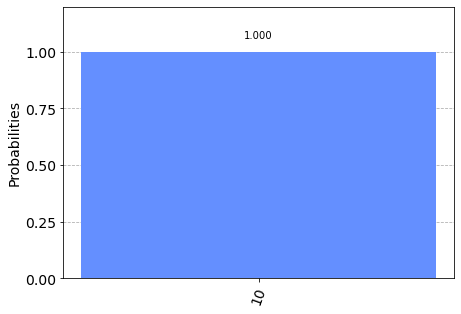

In [13]:
Input = ['gg','ge','eg','ee']
Output = []
Counts = []

for sid in Input:
    f,c = CNOT_Sim(sid)
    Output.append(f)
    Counts.append(c)



U_cnot:


<IPython.core.display.Latex object>

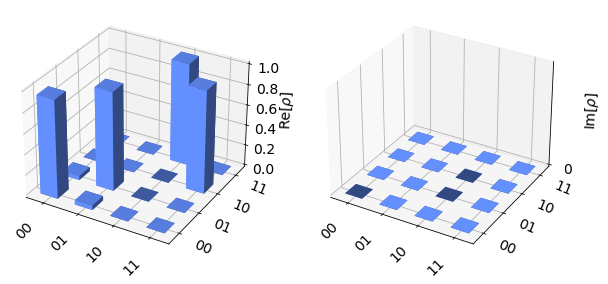

In [18]:
a1 = np.zeros((4,4));
b = ['00','01','10','11']

for i in range(4):
    for j in range(4):
        k = b[j]
        a1[i][j] = Counts[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a1))

display(plot_state_city(a1, title='', figsize=[10,6]))

### With Some Error



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns

Counts: Counter({'00': 973, '01': 27})



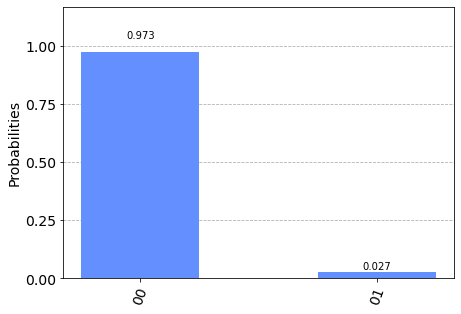



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'01': 968, '00': 32})



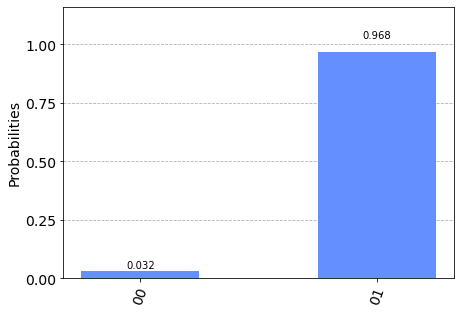



Output for the input state 'eg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'11': 990, '10': 8, '00': 2})



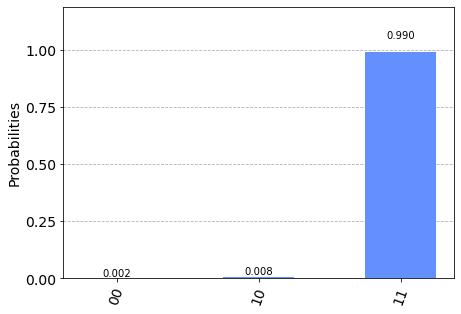



Output for the input state 'ee':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 600ns

Counts: Counter({'10': 996, '11': 4})



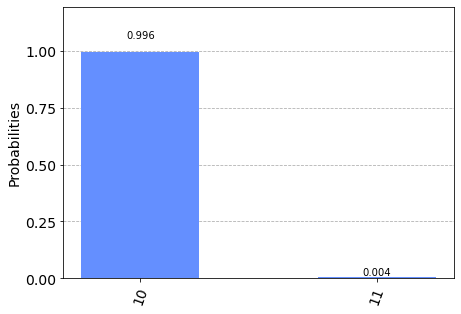

In [19]:
Output1 = []
Counts1 = []

for sid in Input:
    f,c = CNOT_Sim(sid, error=True)
    Output1.append(f)
    Counts1.append(c)



U_cnot:


<IPython.core.display.Latex object>

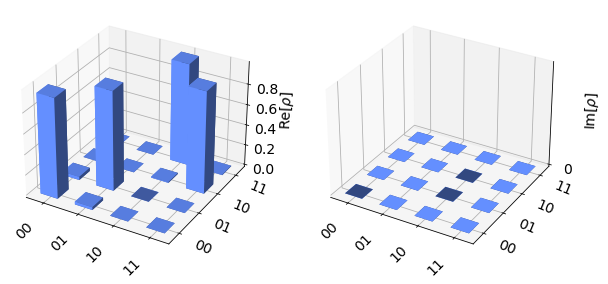

In [20]:
a2 = np.zeros((4,4));

for i in range(4):
    for j in range(4):
        k = b[j]
        a2[i][j] = Counts1[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a2))

display(plot_state_city(a2, title='', figsize=[10,6]))

### With Some More Error



Output for the input state 'gg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 0ns

Counts: Counter({'00': 934, '01': 50, '10': 14, '11': 2})



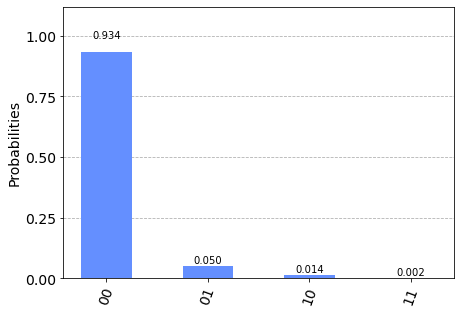



Output for the input state 'ge':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'01': 913, '00': 78, '11': 8, '10': 1})



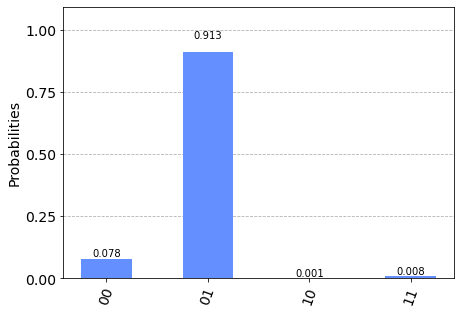



Output for the input state 'eg':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 300ns

Counts: Counter({'11': 894, '10': 62, '01': 42, '00': 2})



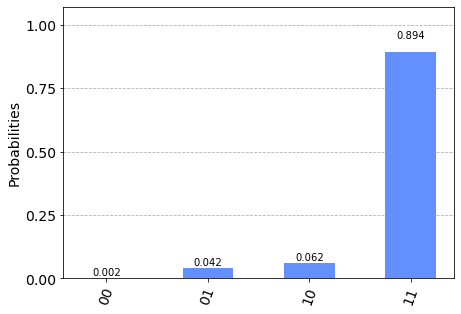



Output for the input state 'ee':-

Prepared state:


<IPython.core.display.Latex object>


Preparation time: 600ns

Counts: Counter({'10': 938, '00': 52, '11': 9, '01': 1})



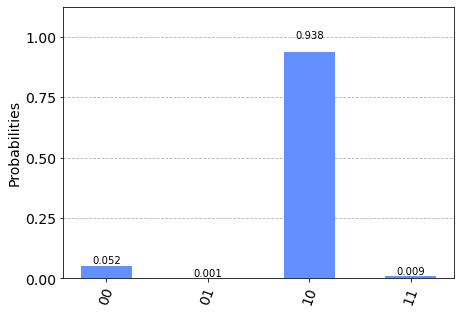

In [21]:
Output2 = []
Counts2 = []

for sid in Input:
    f,c = CNOT_Sim(sid, error2=True)
    Output2.append(f)
    Counts2.append(c)



U_cnot:


<IPython.core.display.Latex object>

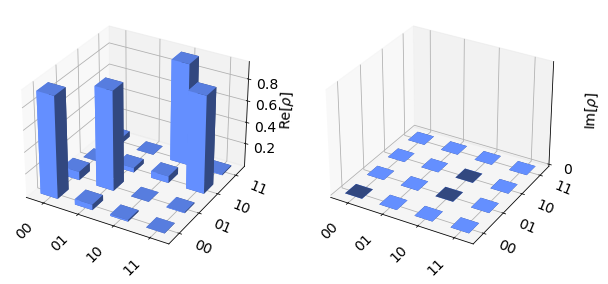

In [22]:
a3 = np.zeros((4,4));

for i in range(4):
    for j in range(4):
        k = b[j]
        a3[i][j] = Counts2[i][k]/1000

print('\n\nU_cnot:')
display(array_to_latex(a3))

display(plot_state_city(a3, title='', figsize=[10,6]))

### Fidelity

In [25]:
u_dag = np.transpose(u)
F = np.trace(np.dot(u,a1))/4
F2 = np.trace(np.dot(u,a2)) / 4
F3 = np.trace(np.dot(u,a3)) / 4
print(f'Fidelity (without error): {F} \nFidelity (with error parameter 1): {F2} \nFidelity (with error parameter 2): {F3}')

Fidelity (without error): 0.98 
Fidelity (with error parameter 1): 0.9817499999999999 
Fidelity (with error parameter 2): 0.9197500000000001
